# Abstract
Dans ce notebook, vous trouverez les différents algorithmes nécessaire au calcul des points d'une cible de tir sur cible subaquatique à partir d'une cible prise en photo. Ces algorithmes se basent sur la librairie OpenCV et son ici implémentés en Python. Les algorithmes sont découpés en plusieurs étapes :
1. Récupération des coordonnées du plastron sur une image
2. Extraction de l'image du plastron
3. Extraction d'un visuel du plastron
4. Récupération des coordonnées des impacts sur le plastron
5. Récupération de la position d'un visuel sur le plastron
6. Agrégation des résultats pour calculer les points finaux de chaque visuel

Import des librairies nécessaires

In [100]:
import math
from enum import Enum

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray



Variables globales

In [101]:
PICTURE_SIZE_SHEET_DETECTION = 1000
IMAGES_SHEET_JPG = 'images/sheet.jpg'


Fonctions utilitaires

In [102]:
def show_image(image: ndarray, cmap: str = None, title: str = None):
    # Convert BGR to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.show()
    
def to_radians(angle):
    return angle * math.pi / 180
    
def rotate_point(center, point, angle):
    s = math.sin(angle)
    c = math.cos(angle)

    # Translate point back to origin
    translated_x = point[0] - center[0]
    translated_y = point[1] - center[1]

    # Rotate point
    rotated_x = translated_x * c - translated_y * s
    rotated_y = translated_x * s + translated_y * c

    # Translate point back
    new_point = (rotated_x + center[0], rotated_y + center[1])

    return new_point


def get_point_on_ellipse(ellipse, angle):
    center, radii,ellipse_angle = ellipse
    radius_x, radius_y = radii
    x = center[0] + math.cos(angle) * (radius_x /2)
    y = center[1] + math.sin(angle) * (radius_y /2)
    rotated_point = rotate_point(center, (x, y),to_radians(ellipse_angle) + to_radians(180))
    # Convert the coordinates to integers
    return (int(x), int(y))

def grow_ellipse(ellipse, factor):
    center, radii, angle = ellipse
    return (center, (radii[0] * factor, radii[1] * factor), angle)


def get_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def get_angle(point1, point2):
    return math.atan2(point2[1] - point1[1], point2[0] - point1[0])

def get_real_distance(center, border, impact):
    length = get_distance(center, border)
    distance = get_distance(center, impact)
    percent = distance / length
    real_length = 25
    millimeter_distance = real_length * percent
    return round(millimeter_distance)

def get_points(distance):
    point = 570
    i = 0
    maximum_impact_distance = 48
    if distance > maximum_impact_distance:
        return 0
    for i in range(5):
        if distance <= 0:
            break
        point -= 6
        distance -= 1
    for i in range(i, 48):
        if distance <= 0:
            break
        point -= 3
        distance -= 1
    return point

def draw_cross_at_coordinates(image: ndarray, coordinates: list, color: tuple = (0, 255, 0), size: int = 20, width: int = 2):
    for coordinate in coordinates:
        #draw a cross at the given coordinate
        cv.line(image, (coordinate[0] - size, coordinate[1]), (coordinate[0] + size, coordinate[1]),
                color,
                width)
        cv.line(image, (coordinate[0], coordinate[1] - size), (coordinate[0], coordinate[1] + size),
                color, width)

Positions des visuels sur le plastron

In [103]:
class Zone(Enum):
    TOP_LEFT = 1
    TOP_RIGHT = 2
    BOTTOM_LEFT = 3
    BOTTOM_RIGHT = 4
    CENTER = 5

Récupération des coordonnées du plastron sur une image

In [104]:
def enhance_image_for_edge_detection(image: ndarray, blur_radius: int = 0):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, saturation, v = cv.split(hsv)
    if blur_radius > 0:
        v = cv.blur(v, (blur_radius, blur_radius))
    return v


def get_edges(image: ndarray, blur_radius: int = 0, canny_threshold_1: int = 100, canny_threshold_2: int = 200):
    image_clone = image.copy()
    if blur_radius > 0:
        image_clone = cv.blur(image_clone, (blur_radius, blur_radius))
    return cv.Canny(image_clone, canny_threshold_1, canny_threshold_2)


def get_biggest_valid_contour(contours):
    biggest_contour = None
    biggest_area = 0
    for contour in contours:
        approx = cv.approxPolyDP(contour, cv.arcLength(contour, True) * 0.01, True)
        if len(approx) != 4 or cv.contourArea(approx) < biggest_area:
            continue
        angles = [math.acos(((p1[0] - p2[0]) * (p3[0] - p2[0]) + (p1[1] - p2[1]) * (p3[1] - p2[1])) /
                            (((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5 *
                             ((p3[0] - p2[0]) ** 2 + (p3[1] - p2[1]) ** 2) ** 0.5)) * 180 / math.pi
                  for i in range(4)
                  for p1, p2, p3 in [(approx[i][0], approx[(i + 1) % 4][0], approx[(i + 2) % 4][0])]]
        if any(angle < 70 or angle > 110 for angle in angles):
            continue
        area = cv.contourArea(approx)
        if area / (PICTURE_SIZE_SHEET_DETECTION * PICTURE_SIZE_SHEET_DETECTION) < 0.1 or area / (
                PICTURE_SIZE_SHEET_DETECTION * PICTURE_SIZE_SHEET_DETECTION) > 0.9:
            continue
        biggest_contour = approx
        biggest_area = area
    return biggest_contour


def coordinates_to_percentage(coordinates, width, height):
    percentage_coordinates = []
    for coordinate in coordinates:
        percentage_coordinates.append((coordinate[0] / width, coordinate[1] / height))
    return percentage_coordinates


def get_sheet_coordinates(sheet_mat: ndarray):
    # Enhance image for edge detection
    enhanced_image = enhance_image_for_edge_detection(
        cv.resize(sheet_mat.copy(), (PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION)),
        blur_radius=5
    )

    # Get edges and dilate them
    dilated_edges = cv.dilate(
        get_edges(cv.bitwise_not(enhanced_image), blur_radius=5),
        cv.getStructuringElement(cv.MORPH_RECT,
                                 (int(PICTURE_SIZE_SHEET_DETECTION / 200), int(PICTURE_SIZE_SHEET_DETECTION / 200))),
        iterations=1
    )
    
    # Find contours
    contours, _ = cv.findContours(cv.bitwise_not(dilated_edges), cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    biggest_contour = get_biggest_valid_contour(contours)
    if biggest_contour is None:
        return None

    # Get coordinates of the biggest contour and convert to percentage
    return coordinates_to_percentage(
        [(biggest_contour[i][0][0], biggest_contour[i][0][1]) for i in range(4)],
        PICTURE_SIZE_SHEET_DETECTION,
        PICTURE_SIZE_SHEET_DETECTION
    )

Test de la récupération des coordonnées du plastron

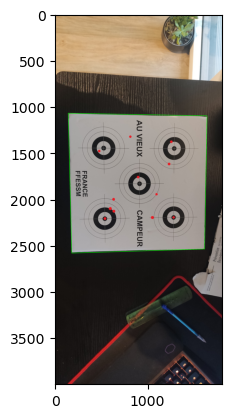

In [105]:
image = cv.imread(IMAGES_SHEET_JPG)
coordinates = get_sheet_coordinates(image)


def draw_sheet_detection_contour(image, coordinates):
    coordinates_len = len(coordinates)
    for i in range(coordinates_len):
        cv.line(image, coordinates[i], coordinates[(i + 1) % coordinates_len], (0, 255, 0), 3)


def percentage_to_coordinates(percentage_coordinates, width, height):
    coordinates = []
    for percentage_coordinate in percentage_coordinates:
        coordinates.append((int(percentage_coordinate[0] * width), int(percentage_coordinate[1] * height)))
    return coordinates


if coordinates is not None:
    height, width, _ = image.shape
    real_coordinates = percentage_to_coordinates(coordinates, width, height)
    draw_sheet_detection_contour(image, real_coordinates)
    show_image(image)
else:
    print('No coordinates found')

Extraction de l'image du plastron

In [106]:
def get_sheet_picture(image: ndarray):
    coordinates = get_sheet_coordinates(image)
    if coordinates is None:
        return None
    height, width, _ = image.shape
    real_coordinates = percentage_to_coordinates(coordinates, width, height)

    approx = np.array(real_coordinates, np.float32)
    target_coordinates = np.array([
        [0, 0],
        [PICTURE_SIZE_SHEET_DETECTION, 0],
        [PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION], [0, PICTURE_SIZE_SHEET_DETECTION]
    ], np.float32)
    transformation_matrix = cv.getPerspectiveTransform(approx, target_coordinates)
    sheet_mat = cv.warpPerspective(image, transformation_matrix,
                                   (PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION))

    return sheet_mat

Test de l'extraction de l'image du plastron

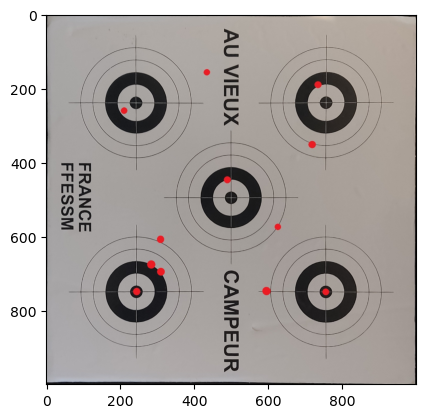

In [107]:
image = cv.imread(IMAGES_SHEET_JPG)
sheet_mat = get_sheet_picture(image)
show_image(sheet_mat)

Extraction d'un visuel du plastron

In [108]:
def get_crop_coordinates(image: ndarray, target_zone: Zone):
    height, width, _ = image.shape
    x1, x2, y1, y2 = 0, width, 0, height

    if target_zone in [Zone.TOP_RIGHT, Zone.BOTTOM_RIGHT]:
        x1 = int(width / 2)
    if target_zone in [Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]:
        y1 = int(height / 2)
    if target_zone in [Zone.TOP_LEFT, Zone.BOTTOM_LEFT]:
        x2 = int(width / 2)
    if target_zone in [Zone.TOP_LEFT, Zone.TOP_RIGHT]:
        y2 = int(height / 2)
    if target_zone == Zone.CENTER:
        x1, y1 = int(width / 4), int(height / 4)
        x2, y2 = width - x1, height - y1

    return {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2}


def get_target_picture(sheet_mat: ndarray, target_zone: Zone):
    sheet_mat_clone = sheet_mat.copy()
    coordinates = get_crop_coordinates(sheet_mat_clone, target_zone)
    return sheet_mat_clone[coordinates['x1']:coordinates['x2'], coordinates['y1']:coordinates['y2']]


Test de l'extraction des visuels du plastron

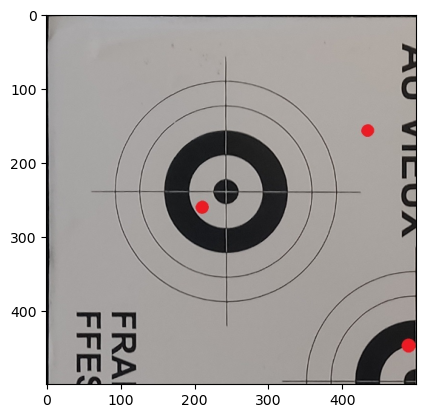

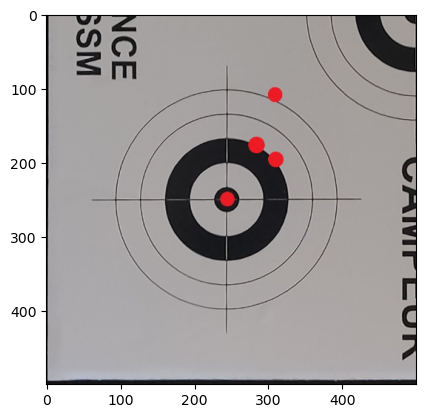

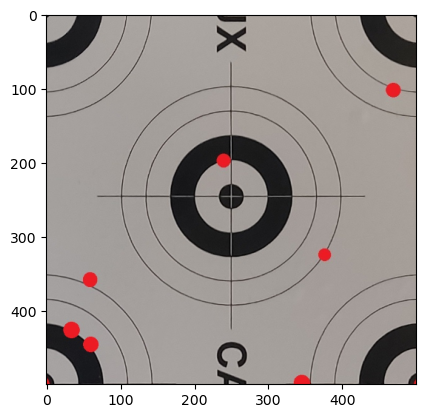

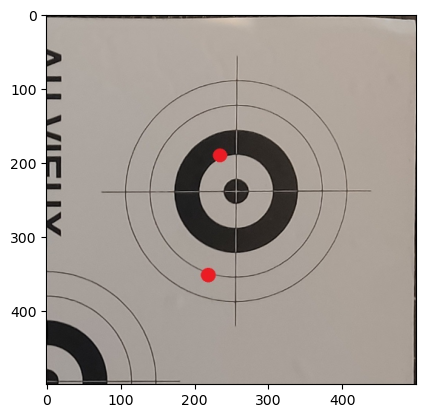

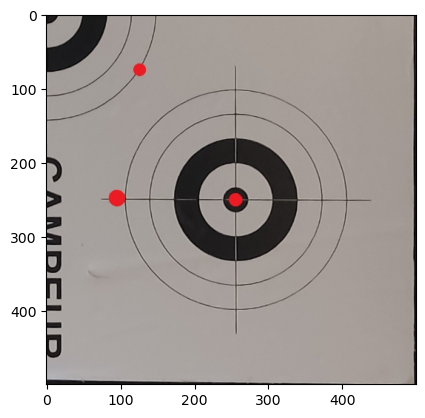

In [109]:
zones = [Zone.TOP_LEFT, Zone.TOP_RIGHT, Zone.CENTER, Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]
for zone in zones:
    target_mat = get_target_picture(sheet_mat, zone)
    show_image(target_mat)



Récupération de la couleur des piges

In [110]:
def get_biggest_contour(contours):
    max_area = 0
    biggest_contour = None
    for contour in contours:
        bounding_rect = cv.boundingRect(contour)
        area = bounding_rect[2] * bounding_rect[3]
        if area > max_area:
            max_area = area
            biggest_contour = contour
    return biggest_contour


def get_impacts_mask(image: ndarray):
    image = cv.blur(image.copy(), (PICTURE_SIZE_SHEET_DETECTION // 100, PICTURE_SIZE_SHEET_DETECTION // 100))
    # hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    # h, saturation, v = cv.split(hsv)
    # min_val, max_val, min_loc, max_loc = cv.minMaxLoc(saturation)
    # min_val = (max_val - min_val) / 1.4 + min_val
    #
    # lower_bound = np.array([min_val], dtype=np.uint8)
    # upper_bound = np.array([max_val], dtype=np.uint8)
    #
    # low = np.full((saturation.shape[0], saturation.shape[1]), lower_bound, dtype=np.uint8)
    # high = np.full((saturation.shape[0], saturation.shape[1]), upper_bound, dtype=np.uint8)
    #
    # cv.inRange(saturation, low, high, saturation)
    #
    # contours, hierarchy = cv.findContours(saturation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # # create a mask image that contains the contour filled in
    # mask = np.zeros_like(saturation)  # Create mask where white is what we want, black otherwise
    # cv.drawContours(mask, contours, -1, 255, -1)  # Draw filled contour in mask
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    lower = np.array([155,25,150])
    upper = np.array([179,255,255])
    # show_image(image)
    mask = cv.inRange(image, lower, upper)

    return mask


Test de la récupération du masque des piges

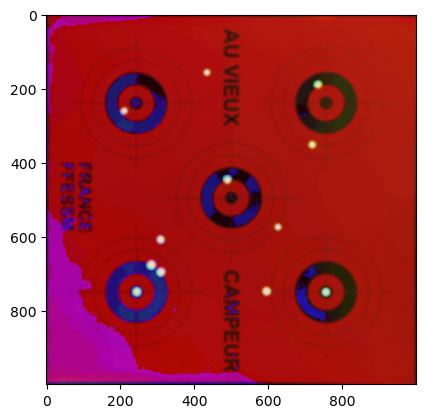

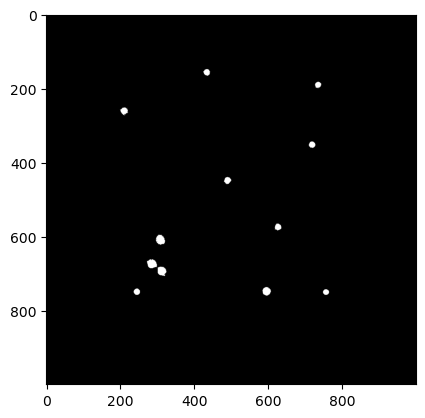

In [111]:
image = cv.imread(IMAGES_SHEET_JPG)
sheet_mat = get_sheet_picture(image)
color = get_impacts_mask(sheet_mat)
show_image(color, cmap='gray')

Récupération des coordonnées des piges

In [112]:
def get_impacts_coordinates(image: ndarray) -> list:
    mask = get_impacts_mask(image)
    contours, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = list(filter(has_more_than_5_points,contours))
    ellipses = [cv.fitEllipse(contour) for contour in contours]
    # get ellipses centers
    centers = [(int(ellipse[0][0]), int(ellipse[0][1])) for ellipse in ellipses]
    return centers
def has_more_than_5_points(contour:ndarray) -> bool:
    return len(contour) > 4




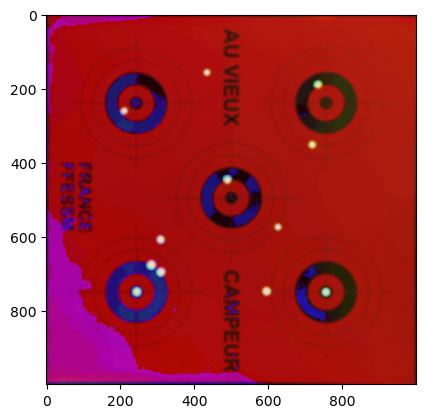

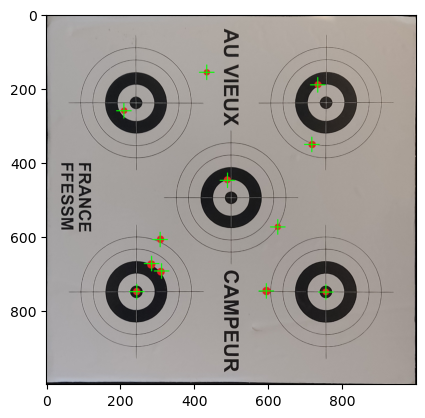

In [113]:
image = cv.imread(IMAGES_SHEET_JPG)
sheet_mat = get_sheet_picture(image)
impacts = get_impacts_coordinates(sheet_mat)
# draw centers on the sheet

draw_cross_at_coordinates(sheet_mat, impacts)

show_image(sheet_mat)

Récupération d'un masque de la couleur des piges (ou de toutes autres couleurs)

In [114]:
def get_color_mask(mat: ndarray, color: tuple):
    color_mat = np.full((1, 1, 3), color, dtype=np.uint8)
    hsv = cv.cvtColor(color_mat, cv.COLOR_RGB2HSV)
    min_val = np.array([hsv[0][0][0] - 10, 100, 50], dtype=np.uint8)
    max_val = np.array([hsv[0][0][0] + 10, 255, 255], dtype=np.uint8)
    hsv_mat = cv.cvtColor(mat, cv.COLOR_BGR2HSV)
    min_mat = np.full((hsv_mat.shape[0], hsv_mat.shape[1], 3), min_val, dtype=np.uint8)
    high_mat = np.full((hsv_mat.shape[0], hsv_mat.shape[1], 3), max_val, dtype=np.uint8)
    mask = cv.inRange(hsv_mat, min_mat, high_mat)
    kernel = np.ones((PICTURE_SIZE_SHEET_DETECTION // 200, PICTURE_SIZE_SHEET_DETECTION // 200), np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=1)
    _, mask = cv.threshold(mask, 127, 255, cv.THRESH_BINARY)
    return mask

Récupération de la position d'un visuel sur le plastron

In [115]:
def get_target_ellipse(mat):
    circle = np.zeros((mat.shape[1], mat.shape[0]), dtype=np.uint8)
    cv.circle(circle, (mat.shape[1] // 2, mat.shape[0] // 2), int(mat.shape[1] / 2.2), (255, 255, 255), -1)

    kernel_size = PICTURE_SIZE_SHEET_DETECTION // 200
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
    hsv = cv.cvtColor(mat.copy(), cv.COLOR_BGR2HSV)
    hsv_channels = cv.split(hsv)
    value = hsv_channels[2]

    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(value)
    max_val = (max_val - min_val) / 2 + min_val

    min_mat = np.full((value.shape[0], value.shape[1]), min_val, dtype=value.dtype)
    high_mat = np.full((value.shape[0], value.shape[1]), max_val, dtype=value.dtype)
    value_mask = cv.inRange(value, min_mat, high_mat)
    cv.bitwise_and(value_mask, circle, value_mask)

    close = cv.morphologyEx(value_mask, cv.MORPH_CLOSE, kernel)
    close = cv.morphologyEx(close, cv.MORPH_OPEN, kernel)

    contours, _ = cv.findContours(close, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    biggest_contour = max(contours, key=cv.contourArea)
    ellipse = cv.fitEllipse(biggest_contour)
    for i in range(10):
        empty = np.zeros(mat.shape, dtype=np.uint8)
        cv.ellipse(empty, ellipse, (255, 255, 255), -1)
        empty_gray = cv.cvtColor(empty, cv.COLOR_BGR2GRAY)
        
        xor = cv.bitwise_xor(empty_gray, close)
        cv.bitwise_or(close, xor, xor)
        contours, _ = cv.findContours(xor, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        biggest_contour = max(contours, key=cv.contourArea)
        ellipse = cv.fitEllipse(biggest_contour)
        if ellipse[1][0] < ellipse[1][1] * 0.7 or ellipse[1][0] > ellipse[1][1] * 1.3:
            raise ValueError('Problem during visual detection')
    return ellipse

Récupération de l'emplacement des visuels sur le plastron

In [116]:
def get_targets_ellipse(image: ndarray):
    zones = [Zone.TOP_LEFT, Zone.TOP_RIGHT, Zone.CENTER, Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]
    ellipsis = {}
    for zone in zones:
        target_mat = get_target_picture(image, zone)
        ellipsis[zone] = get_target_ellipse(target_mat)
    return ellipsis

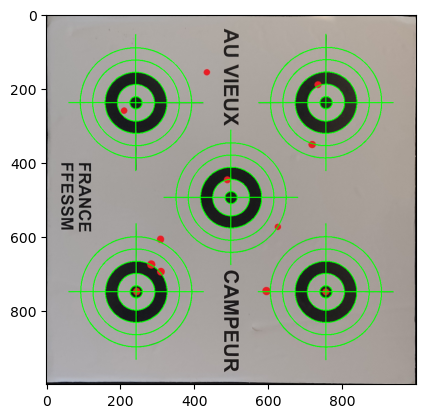

In [117]:
def target_coordinates_to_sheet_coordinates(ellipsis: dict):
    new_ellipsis = {}
    for key, value in ellipsis.items():
        if (key == Zone.TOP_LEFT):
            new_ellipsis[key] = (value[0], value[1], value[2])
        elif (key == Zone.TOP_RIGHT):
            new_ellipsis[key] = ((value[0][0], value[0][1] + PICTURE_SIZE_SHEET_DETECTION // 2), value[1], value[2])
        elif (key == Zone.BOTTOM_LEFT):
            new_ellipsis[key] = ((value[0][0] + PICTURE_SIZE_SHEET_DETECTION // 2, value[0][1]), value[1], value[2])
        elif (key == Zone.BOTTOM_RIGHT):
            new_ellipsis[key] = (
            (value[0][0] + PICTURE_SIZE_SHEET_DETECTION // 2, value[0][1] + PICTURE_SIZE_SHEET_DETECTION // 2),
            value[1], value[2])
        elif (key == Zone.CENTER):
            new_ellipsis[key] = (
            (value[0][0] + PICTURE_SIZE_SHEET_DETECTION // 4, value[0][1] + PICTURE_SIZE_SHEET_DETECTION // 4),
            value[1], value[2])
    return new_ellipsis


image = cv.imread(IMAGES_SHEET_JPG)
sheet_mat = get_sheet_picture(image)
coordinates = get_targets_ellipse(sheet_mat)
coordinates = target_coordinates_to_sheet_coordinates(coordinates)
#iterate key and value
for key, ellipse_contrat in coordinates.items():
    
    drawing_width = 2
    
    # Draw the ellipse
    target_color = (0, 255, 0)
    # Grow the ellipse
    ellipse_cross_tip = grow_ellipse(ellipse_contrat, 2.2)
    ellipse_mouche = grow_ellipse(ellipse_contrat, 0.2)
    ellipse_petit_blanc = grow_ellipse(ellipse_contrat, 0.6)
    ellipse_moyen_blanc = grow_ellipse(ellipse_contrat, 1.4)
    ellipse_grand_blanc = grow_ellipse(ellipse_contrat, 1.8)
    # Draw the ellipses
    cv.ellipse(sheet_mat, ellipse_contrat, target_color, drawing_width)
    cv.ellipse(sheet_mat, ellipse_mouche, target_color, drawing_width)
    cv.ellipse(sheet_mat, ellipse_petit_blanc, target_color, drawing_width)
    cv.ellipse(sheet_mat, ellipse_moyen_blanc, target_color, drawing_width)
    cv.ellipse(sheet_mat, ellipse_grand_blanc, target_color, drawing_width)
    
    
    
    top_point = get_point_on_ellipse(ellipse_cross_tip, to_radians(90))
    bottom_point = get_point_on_ellipse(ellipse_cross_tip, to_radians(270))
    left_point = get_point_on_ellipse(ellipse_cross_tip, to_radians(180))
    right_point = get_point_on_ellipse(ellipse_cross_tip, to_radians(0))
    cv.line(sheet_mat, top_point, bottom_point, target_color, drawing_width)
    cv.line(sheet_mat, left_point, right_point, target_color, drawing_width)
show_image(sheet_mat)

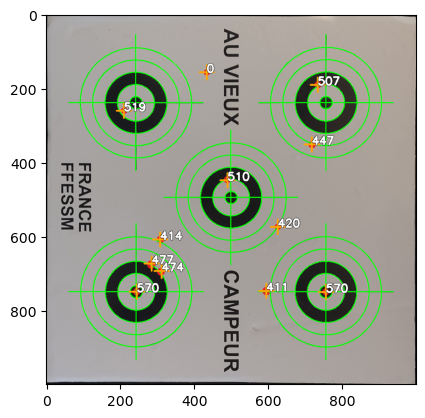

In [118]:
draw_cross_at_coordinates(sheet_mat, impacts,color=(0,165,255),width=3)

for impact in impacts:
    min_distance = float('inf')
    closest_zone = None
    
    for key,coordinate in coordinates.items():
        distance = get_distance(impact, coordinate[0])
        if min_distance > distance:
            min_distance = distance
            closest_zone = key
    
    if closest_zone is None:
        raise ValueError('Aucune zone trouvée')
    
    rad_angle = get_angle(impact, coordinates[closest_zone][0])
    angle = rad_angle + to_radians(360)
    ellipse_angle = to_radians(coordinates[closest_zone][2] + 360)
    angle = angle - ellipse_angle
    point_on_ellipse = get_point_on_ellipse(
        coordinates[closest_zone],
        angle
    )
    point_on_ellipse = rotate_point(
        coordinates[closest_zone][0],
        point_on_ellipse,
        ellipse_angle + to_radians(180)
    )
    
    real_distance = get_real_distance(
        coordinates[closest_zone][0],
        point_on_ellipse,
        impact
    )
    points = get_points(real_distance)
    
    cv.putText(
        sheet_mat,
        str(points),
        impact,
        cv.FONT_HERSHEY_SIMPLEX,
        1,
        [0, 0, 0, 255],
        6
    )
    cv.putText(
        sheet_mat,
        str(points),
        impact,
        cv.FONT_HERSHEY_SIMPLEX,
        1,
        [255, 255, 255, 255],
        3
    )

show_image(sheet_mat)

# Generate 1000 random images of a target with one impact and save them in a folder called the number of points of the impact 

In [119]:
import os
import cv2 as cv
import uuid
path = 'images/sheet_dataset'
i = 0
import random

zones = [Zone.TOP_LEFT, Zone.TOP_RIGHT, Zone.CENTER, Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]

for filename in os.listdir(path):
    sheet_mat = cv.imread(os.path.join(path,filename))
    sheet_mat = get_sheet_picture(sheet_mat)
    if sheet_mat is not None:
        cv.imwrite('images/cropped_sheet_dataset/'+str(i)+'.jpg',sheet_mat)
        i+=1

i = 0
for zone in zones:
    for filename in os.listdir("images/cropped_sheet_dataset"):
        sheet_mat = cv.imread(os.path.join("images/cropped_sheet_dataset",filename))
        target_mat = get_target_picture(sheet_mat, zone)
        if target_mat is not None:
            if not cv.imwrite('images/target_dataset/' + str(i) + "_" + str(zone.name) + '.jpg', target_mat):
                print('error')
            i+=1
        

for filename in os.listdir("images/target_dataset"):
    for i in range(1000):
        target_mat = cv.imread(os.path.join("images/target_dataset",filename))
        ellipse = get_target_ellipse(target_mat)
        # draw a circle at random position x,y
        
        # Generate random x and y coordinates within the image dimensions
        x = random.randint(0, target_mat.shape[1])
        y = random.randint(0, target_mat.shape[0])
        
        # Define the center, radius, color, and thickness of the dot
        center = (x, y)
        radius = 13
        color = (0, 0, 255)  # Red color in BGR
        thickness = -1  # Full circle
        
        # Draw the dot on the image
        cv.circle(target_mat, center, radius, color, thickness)
    
        impacts = get_impacts_coordinates(target_mat)
    
        rad_angle = get_angle(impacts[0], ellipse[0])
        angle = rad_angle + to_radians(360)
        ellipse_angle = to_radians(ellipse[2] + 360)
        angle = angle - ellipse_angle
        point_on_ellipse = get_point_on_ellipse(
            ellipse,
            angle
        )
        point_on_ellipse = rotate_point(
            ellipse[0],
            point_on_ellipse,
            ellipse_angle + to_radians(180)
        )
        
        real_distance = get_real_distance(
            ellipse[0],
            point_on_ellipse,
            impacts[0]
        )
        points = get_points(real_distance)
        folder = 'images/impact_dataset/' + str(points)
        if not os.path.exists(folder):
            os.makedirs(folder)
        unique_id = str(uuid.uuid4())
        cv.imwrite('images/impact_dataset/' + str(points) + '/' + str(unique_id) + '.jpg', target_mat)



FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'images/cropped_sheet_dataset'